# Notebook X: performing large searches for exoplanet (candidates) with TIKE

## Learning objectives
- rapidly download large amounts of TESS data
- work with the large TESS data collections

## Introduction
Studying exoplanet demographics (the frequency of different types of exoplanets) lets us tackle some of the biggest questions in exoplanet science: How do planets form? How do they evolve? Are there any exoplanets that are like the Earth? 

TIKE is an excellent resource for computing occurrence rates. There are other resources that explain TIKE elsewhere; we summarize some of the main TIKE benefits in this case below:

- your computations are performed "close" to MAST data, meaning that it's quicker to access lightcurves.
- you don't have to download data to your own computer, saving *storage* too.
- you don't have to use your own computational resources.
- in most cases, the scientific computing environments are already set up. you don't have to spend time wrangling with environments.


[todo: increase or decrease the amount that TIKE is talked up?]


In this notebook, we'll take one of the first major steps to calculating occurrence rates: searching a large selection of lightcurves for exoplanets. Note: our abridged version may produce spurious planetary candidates! While we favor a concise narrative and rapid notebook execution time here, we'll note when applicable where a more robust approach should be taken for, e.g., a scientific publication.

# 1. Import packages, set constants

Before diving into planet-finding, we will import some necessary packages.

- `astropy` contains a number of utility functions for working with astronomical data.
- `astroquery` lets us easily query the astronomical databases that contain the TESS lightcurves.
- `numpy` is used for array manipulation.
- `matplotlib.pyplot` is used to display images and plot datasets.
- `tqdm` is a lightweight progress bar that we can use to track how long our calculations will take.
- `pandas` let us interact easily with CSV files that we'll be downliading.
- `os` and `concurrent` let us make informed choiced when multithreading.

In [1]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.timeseries import BoxLeastSquares


from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.exceptions import InvalidQueryError


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


import os
from concurrent.futures import ThreadPoolExecutor, as_completed

We will also *install* one package into our environment: the `batman` package. This tool will let us easily model exoplanet transits during our planet searches.

In [2]:
!pip install batman-package

  Using cached batman_package-2.4.9-cp311-cp311-linux_x86_64.whl


With our package installed, we can safely import it.

In [3]:
import batman

We'll now set a few constants and conversion factors so that we can use them later on.

In [4]:
G = const.G.si.value
days_to_seconds = (u.day).to(u.s)
r_earth_to_meters = (u.R_earth).to(u.m)
m_sun_kg = (u.M_sun).to(u.kg)
r_sun_m = (u.R_sun).to(u.m)

We'll also make sure that we retrieve cloud files from AWS, making our data access stage much faster.

In [5]:
# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


# 2. Find stars

Generally, the first step to finding planets is figuring out what host stars you want to search for orbiting planets. In this study, we want to find the occurrence of hot Jupiters around Sun-like stars. We'll make some cuts so that we're looking for bright, high-gravity, solar-mass stars:

- *bright*: TESS was designed to look for transits around bright stars. These stars' TESS data will have high signal to noise ratios, so we have better chances of finding planetary signals in them.
- *high-gravity*: especially low-gravity stars tend to be evolved off the stellar main-sequence, and therefore not very Sun-like.
- *solar-mass*: solar-mass stars on the stellar main sequence tend to be quite solar.

To find these stars, we'll query the TESS Candidate Target List (CTL) — a list of stars pre-selected by the TESS team to be likely good targets for transit detection (e.g., bright, low flux contamination).

In [6]:
%%time

catalog_data = Catalogs.query_criteria(catalog="Ctl",
                                       Tmag=[0, 10.5], # remember, lower magnitudes are brighter than higher ones!
                                      logg=[4.1,400], # solar logg ~ 4.4
                                      mass=[0.8, 1.05]) # these masses are in solar radii

CPU times: user 15.8 s, sys: 1.65 s, total: 17.4 s
Wall time: 1min


Let's take a look at this catalog data.

In [7]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str10
83940523,20190415,--,2267-01192-1,621-000009,00000410+3411189,--,J000003.89+341118.1,2875125810310195712,48962970,--,STAR,tmgaia2,0.0169976360306548,34.1885450373917,tmgaia2,-224.498,0.24663,-54.9296,0.155716,gaia2,19.0591,0.212669,gaia2,110.970220773112,-27.4871944672489,15.1354693242748,31.0276744291869,9.145,0.028,8.493,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.249,0.017,6.94,0.016,6.885,0.017,AAA-111-111-000-0-0,nan,6.851,0.062,6.871,0.019,6.883,0.016,6.824,0.085,8.33714,0.00027,7.8954,0.006,gbprp,gaia2,5704.0,126.167,4.44826,0.0772625,nan,nan,0.998172,0.0498392,1.02,0.123428,1.02562,0.217127,DWARF,0.9502178,0.03231535,52.401,0.58845,0.0,0.0,90,0.00158335292,--,--,0.00585454023552081,0.0,0.0,--,0.100151,0.146704,0.0498518,0.0498266,0.20157,0.232683,0.0784076,0.0761174,0.0362655,0.0283652,0.582,0.5949,bj2018,114.575,137.759,dered0,8.69435,0.000975,7.85136,0.00121,1,--,tycho2v3,tycho2b3,planetcandidate,4.00141383686189,2.41580491918867,0.0158291195166365,34.1883085404878,0.125382565601784,0.10323808392345,1,0,833
118005970,20190415,--,1735-00930-1,596-000142,00030313+2901556,1237663307455004777,J000303.12+290155.2,2854992481095306752,47911378,--,STAR,tmgaia2,0.763038317145479,29.0321173400183,tmgaia2,-12.5026,0.0689185,-37.0456,0.0320888,gaia2,8.55616,0.0487874,gaia2,110.362199420804,-32.6558834136927,13.1170981454118,26.1435853405611,11.964,0.224,11.466,0.015,14.8854,0.00715932,11.7441,0.000664854,10.9885,0.000551802,10.7408,0.00065727,11.0516,0.00217147,9.603,0.023,9.193,0.021,9.101,0.018,AAA-222-111-000-0-0,nan,9.04,0.023,9.073,0.02,9.005,0.031,8.383,0.223,10.9284,0.000526,10.3891,0.006,rered,gaia2,5203.0,130.632,4.52689,0.0856953,nan,nan,0.8493,0.0498492,0.885,0.111835,1.44464,0.349108,DWARF,0.476246566,0.0156704,116.487,0.667,0.0167619,0.009038565,60,0.00107958447,--,--,0.00207309863826472,0.00724383,0.0108333,panstarrs,0.0990487,0.124622,0.0562578,0.0434407,0.318475,0.37974,0.108065,0.0633256,0.015635,0.0157058,0.664,0.67,bj2018,119.297,141.967,dered,11.3888,0.000798,10.3442,0.000652,1,--,tycho2v3,tycho2b3,planetcandidate,1.10420925200251,0.497755073291291,0.762976750525541,29.0319578381425,0.0406243496299374,0.0194121021597093,1,0,18347
11800742

This is a pretty long table, totalling 53056 stars.

To get a better sense of the data products we'll be working with, let's download a single lightcurve associated with one of these stars.

In [8]:
# next, download a single star from this catalog to inspect the data type we're working with.

In [9]:
%%time
TESS_table = Observations.query_criteria(target_name=catalog_data['ID'][2]
                                         , obs_collection="TESS"
                                         , dataproduct_type='timeseries'
                                         ) 

data_products = Observations.get_product_list(TESS_table) 


CPU times: user 29.7 ms, sys: 29 ms, total: 58.7 ms
Wall time: 469 ms


It's relatively quick to download a table of data products (less than half a second). Let's select one of the lightcurves and open one of the associated FITS files.

In [10]:
# Keep only the science products
filtered = Observations.filter_products(data_products, productType="SCIENCE")

# Be selective about the columns we display
cols = ['obs_id', 'description', 'productSubGroupDescription']

# Look at the first five rows of the filtered results
filtered[0:10][cols]
ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
# ex_id = filtered['obs_id'][0]

lc_prod = Observations.filter_products(data_products
                                      , obs_id = ex_id   
                                      )
# Get the cloud uris for these files
lc_uri = Observations.get_cloud_uris(lc_prod)[0]

#open the lc file
lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})

/opt/conda/envs/tess/lib/python3.11/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Great! Now, let's examine the columns available to us in this lightcurve.

In [11]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

There are two flux columns: SAP flux and PDCSAP flux. The SAP flux is closer to raw TESS data. The PDCSAP_FLUX is derived from SAP flux, but it's been cleaned of longer-term trends.

Text(0.5, 0, 'TIME  (BJD-2457000)')

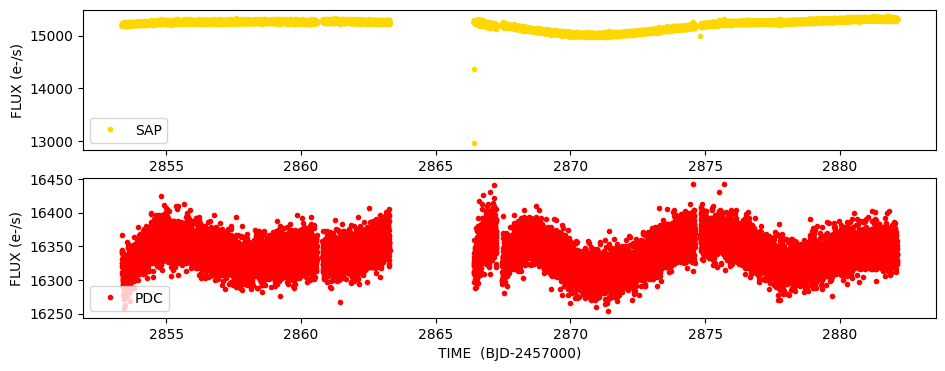

In [12]:
sapflux = lc['SAP_FLUX']
pdcflux = lc['PDCSAP_FLUX']
time_lc = lc['TIME']

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

This definitely looks like a lightcurve! The PDC data, as expected, are smoother and seem more evenly distributed about a median value.

# Next: aggregate all the lightcurves!

Now we know how to access a single lightcurve. To calculate our occurrence rates, of course, we'll need to download many lightcurves from many stars. 

The neatest way to do this is to write a function that accesses TESS lightcurves, then loop over that function for all the stars we want to query. Along the way, we'll incorporate a few tricks to speed things up.

The below function encapsulates the work we've already done above.

In [13]:
def fetch_and_save_data(catalog_id):
    """
    Accesses and saves data from a TESS target.

    Inputs
    ------
        :catalog_id: (int) TESS Input Catalog (TIC) ID.

    Outputs
    -------
    None

    Side effects
    ------------
    Writes the file `lc_data/{catalog_id}.npy`, containing the timestamps of the lightcurve, the PDCSAP flux, 
    and the uncertainty on the PDCSAP flux.
    """
    TESS_table = Observations.query_criteria(target_name=catalog_id
                                             , obs_collection="TESS"
                                             , dataproduct_type='timeseries'
                                             ) 
    try:
        data_products = Observations.get_product_list(TESS_table) 
    except InvalidQueryError:
        return
        
    # Keep only the science products
    filtered = Observations.filter_products(data_products, productType="SCIENCE")
    
    # Be selective about the columns we display
    cols = ['obs_id', 'description', 'productSubGroupDescription']
    
    # Look at the first five rows of the filtered results
    filtered[0:10][cols]
    ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
    
    lc_prod = Observations.filter_products(data_products
                                          , obs_id = ex_id   
                                          , productSubGroupDescription = "LC")
    
    # Get the cloud uris for these files
    lc_uri = Observations.get_cloud_uris(lc_prod)[0]

    #open the lc file
    lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})
    
    #Take a peek at the FITS file we downloaded
    lc = lc_fits[1].data
    sapflux = lc['SAP_FLUX'] #SAP flux column
    pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
    pdcflux_err = lc['PDCSAP_FLUX_ERR']
    time_lc = lc['TIME'] #time column
    
    np.save(f'lc_data/{catalog_id}.npy', [time_lc, pdcflux, pdcflux_err])



Let's test this function out on a single star.

In [14]:
fetch_and_save_data(catalog_data['ID'][2])

Let's check that this function worked correctly by checking if a file was written.

In [15]:
ls lc_data | head -n 1

100413992.npy
ls: write error: Broken pipe


Great! Our file has been written.

Now, we want to *parallelize* our computation. What this means is we want to access multiple lightcurve files simultaneously.

We'll use wthis with the Python multithreading package. Multithreading is a very rich and complex subject (link something here), but for our purposes we can just think of it as splitting up our machine into different sections that each perform a separate task. Because our option is largely limited by 

In [16]:
# explain how to set the max number of workers
os.cpu_count() 


4

In [17]:

# Use ThreadPoolExecutor to download files in parallel
total_tasks = len(catalog_data['ID'][::100])
progress_bar = tqdm(total=total_tasks, position=0, leave=True)

max_workers = 5  # Adjust this based on your system's capabilities

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(fetch_and_save_data, catalog_id) for catalog_id in catalog_data['ID'][::100]]
    for future in as_completed(futures):
        progress_bar.update(1)
        
# Optionally wait for all futures to complete
for future in futures:
    future.result()

100%|██████████| 531/531 [02:07<00:00,  4.04it/s]

# Next: search the lightcurves for planets.
We now have our processed data products. The next step is to search them for planets!

One of the standard ways to do this is with the [Box-Least Squares algorithm](https://arxiv.org/abs/astro-ph/0206099). This approach takes advantage of the facts that 1) planetary transits are expected to be periodic, and 2) transits are more or less shaped like boxes (excluding effects like limb-darkening). Loosely, the algorithm works similarly to the Lomb-Scargle periodogram, with the key difference that the signal being tested is a box car, instead of a sine wave.

Let's load in a light curve and test out the algorithm.

In [18]:
time, flux, flux_err  = np.load('lc_data/293465600.npy')

time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]
model = BoxLeastSquares(time, flux, flux_err)

For this example, we'll search for planets with periods between 0.5 and 10 days. The lower limit is physical: planets can only have periods that are so short before their orbits are unstable. The upper limit is statistical: [Nyquist sampling](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) dictates that you can only detect periodic signals with frequencies at most *half* your observational baseline. That is, you need to be able to detect your signal twice in a dataset in order to measure its period. Because TESS sectors are generally 27 days long, we'll set our upper limit to 13 days. We'll test 1000 trial periods for the purposes of this exploratory notebook.

In [63]:
lower_limit = 0.5 #days
upper_limit = 13 # days
n_periods_tested = 1000
periods = np.linspace(lower_limit, upper_limit, n_periods_tested)  # in units of days.

To search for the planets, we will need to specify a transit duration. At first, this may seem like a daunting task — will we have to provide another axis to our search?

To keep things computationally feasible for this notebook, let's appeal to the original goal: finding hot Jupiters orbiting Sun-like stars. Because we're searching for a specific planet type (with a certain orbital period range) orbiting a certain type of star, there should be an expected transit duration for our search. Let's calculate what that duration is.

Assuming a circular orbit, the transit duration is (Seager & Mallén-Ornelas 2003):

$$T_{\rm dur} =\frac{P}{\pi} \arcsin\bigg{(}\frac{\sqrt{1 - a^2/R_{\star}^2 \cos^2(i)}}{a^2/R_{\star}^2\sin(i)}\bigg{)},$$

where $P$ is the orbital period, $a$ is the semimajor axis, $R_{\star}$ is the orbital inclination, and $i$ is the orbital inclination.

What do we know? We have the mass of the planet and the star, and the orbital period is about a day. From Kepler's third law we can then calculate the semimajor axis. 

Let's code this up!

In [21]:
def calc_a_from_period(period, planet_mass, stellar_mass):
    """

    Given the period, uses Kepler's Third Law to calculate the semimajor axis in meters.

    Inputs
    -----
        :period: orbital period of planet (s)
        :planet_mass: mass of planet (kg)
        :stellar_mass: mass of star (kg)

    Outputs
    ------
        :a: semimajor axis(meters)
    """
    total_mass = planet_mass + stellar_mass
    a_cubed = (const.G.si.value * total_mass * period**2) / (4 * np.pi**2)
    a = a_cubed**(1/3)
    return a

In [78]:
def calc_t_dur(P, a, rstar, i):
    """
    Calculates the transit duration, in seconds, of a planet.

    Inputs
    ------
        :P: the orbital period of the planet, in seconds.
        :a: the semimajor axis of the planet, in meters.
        :rstar: the radius of the star, in meters.
        :i: the inclincation of the planet, in radians. an inclination of 0 is face-on (non-transiting); an inclination of pi/2 is perfectly transiting.
    """
    a_r_2 = (a/rstar)**2
    return (P / np.pi) * np.arcsin(np.sqrt(1 - a_r_2 * np.square(np.cos(i))) / (a_r_2 * np.sin(i)))
    

In [79]:
period = (3 * u.day).si.value # 1 day orbital period, expressed in seconds
planet_mass = (1 * u.M_jup).si.value # jupiter mass
stellar_mass = (1 * u.M_sun).si.value # solar mass
stellar_radius = (1 * u.R_sun).si.value # solar radius
inclination  = np.pi/2 # transiting across the stellar equator

a = calc_a_from_period(period, planet_mass, stellar_mass)
t_dur = calc_t_dur(period, a, stellar_radius, inclination)

(t_dur * u.s).to(u.hour), (t_dur * u.s).to(u.day)

(<Quantity 0.29891527 h>, <Quantity 0.0124548 d>)

In [81]:
(t_dur * u.s).to(u.day).value

0.012454802805972288

Great! Now let's express this transit duration in days and find our planets.

In [82]:
t_dur = (t_dur * u.s).to(u.day).value
t_dur

0.012454802805972288

In [83]:
results = model.power(periods, t_dur)  # The second argument is the duration of the transit (in days)

We can access the best-fitting period from our planet search with the below cell.

In [84]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 5.217217217217217


Now let's plot up the signal-to-noise of the tested planetary signals at all tested periods, paying special attention to the best-fitting period.

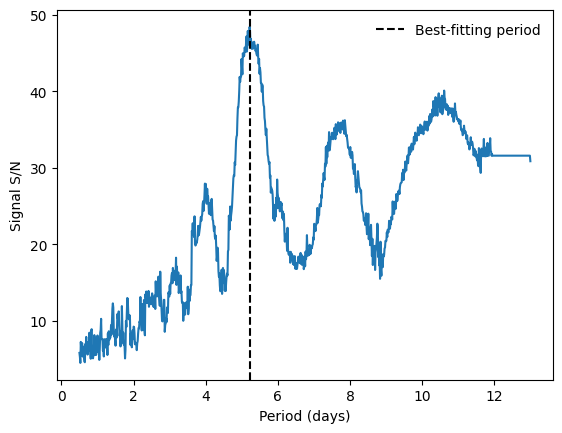

In [89]:
plt.plot(results.period, results.depth_snr)
plt.axvline(best_period, color='black', linestyle='--', label='Best-fitting period')
plt.xlabel('Period (days)')
plt.ylabel('Signal S/N')
plt.legend(frameon=False)

Awesome! Now let's wrap this code in a function and apply it to all the selected planets.

In [90]:
def do_bls(time, flux, flux_err):
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    # todo: check even and odd
    return results, stats

In [91]:
def do_inversion_test(time, flux, flux_err):
    inverted_flux = -1 * flux + 2* np.mean(flux)
    results, stats = do_bls(time, inverted_flux, flux_err)
    return results, stats

In [92]:
def find_planet(ticid):
    """
    This is ourn main function to find a planet. We basically perform the box-least squares algorithm, 
    then do a simple inversion test.
    """
    try:
        time, flux, flux_err  = np.load(f'lc_data/{ticid}.npy')
    except FileNotFoundError:
        return False

    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, t_dur)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    
    # do the inversion test here? if we invert it and find the transit, not good.
    if len(stats['transit_times']) >= 2 and results.depth_snr[max_power] >= 10:

        # test for variability
        inverted_results, inverted_stats = do_inversion_test(time, flux, flux_err)
        if len(inverted_stats['transit_times']) < 2 or inverted_results.depth_snr[max_power] < 10:
            return True

    # todo: The harmonic_delta_log_likelihood is the difference in log likelihood between a sinusoidal model and the transit model. If harmonic_delta_log_likelihood is greater than zero, the sinusoidal model is preferred.

            
    return False

        
        # we found a planet then!

In [93]:
found_planets = np.zeros(len(catalog_data['ID'][::100]))
for i, catalog_id in tqdm(enumerate(catalog_data['ID'][::100]), total=len(found_planets), position=0):
    found_planets[i] = find_planet(catalog_id)

100%|██████████| 531/531 [02:49<00:00,  3.13it/s]


Great! Let's quickly see how many planets our simple pipeline found.

In [96]:
np.sum(found_planets)

4.0

The simplest way to calculate occurrence rates is to divide the number of planets found by the number of stars searched. Let's go ahead and try that out.

In [97]:
np.sum(found_planets)/len(found_planets)

0.007532956685499058

This number is about an order of magnitude higher than expected hot Jupiter occurrence rate (about 0.6% around G stars; [Beleznay & Kunimoto 2022](https://academic.oup.com/mnras/article/516/1/75/6654884)).

There's a good reason that our estimate is so much higher: we must have a lot of false positives! More advanced planet-finding and occurrence rate pipelines take multiple additional factors into consideration:

- some of the planet signals are astrophysical (e.g., eclipsing binary) or instrumental (e.g., the Kepler "rolling bands") false positives.
- we are not sensitive to planets orbiting in all configurations via the transit method (i.e., most planets do not transit).
- our pipeline is equally sensitive to all signal sizes, e.g. smaller planets around bigger stars.

[aaand end the notebook! couple ways to extend: add error bars, one line of code, a little statistics? add more testing to the planet detection pipeline?]